# Galaxy Classification with Vision Transformer (Pytorch)

Data:

https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge



References:

1. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

2. https://pytorch.org/vision/stable/models.html

3. https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

4. https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

5. https://cs231n.github.io/transfer-learning/

6. https://github.com/joshualin24/vit-pytorch/blob/main/examples/galaxy_classification.ipynb



## Check GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-05a55fc1-fe46-4199-3d72-5286c9b0c05c)


## Install Vision Transformer (ViT)

In [2]:
! pip -q install vit_pytorch linformer

## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import os
import zipfile
from copy import deepcopy

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# vision transformer
from linformer import Linformer
from vit_pytorch.efficient import ViT

cuda:0


## Unzip images

Before running the code, please upload `images_train.zip`, `images_valid.zip` and `images_test.zip` to the workspace.

We upzip these 3 files, and place"

- all training images (n=39,410) into the folder `images_train`
- all validation images (n=9,852) into the folder `images_valid`, and
- all test images (n=12,316) into the folder `images_test`.

We create the folders first if they don't exist.

In [ ]:
## The unzipping function
def unzipping(zip_file_name, dest_dir):
    """
    Arguments
        zip_file_name: (str) the file name of the zip file
        dest_dir: (str) the name of the destination folder
    """
    # check if the destination folder exists. Create one if not.
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    
    # unzipping
    zip_f = zipfile.ZipFile(zip_file_name, 'r')
    zip_f.extractall(path=dest_dir)
    zip_f.close()

In [ ]:
## Unzip training, validation, and test images
unzipping('images_train.zip', 'images_train')
unzipping('images_valid.zip', 'images_valid')
unzipping('images_test.zip', 'images_test')

## Custom Datasets

In [4]:
## Custom Galaxy Zoo Dataset
class GalaxyZooDataset(Dataset):
    """Galaxy Zoo Dataset"""

    def __init__(self, csv_file, images_dir, transform=None):
        """
        Args:
            csv_file (string): path to the label csv
            images_dir (string): path to the dir containing all images
            transform (callable, optional): transform to apply
        """
        self.labels_df = pd.read_csv(csv_file)
        self.images_dir = images_dir
        self.transform = transform
    
    def __len__(self):
        """
        Returns the size of the dataset
        """
        return len(self.labels_df)

    def __getitem__(self, idx):
        """
        Get the idx-th sample.
		Outputs the image (channel first) and the true label
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # galaxy ID
        galaxyid = self.labels_df.iloc[idx, 0].astype(str)
		# path of the image
        image_path = os.path.join(self.images_dir, galaxyid + '.jpg')
		# read the image
        image = Image.open(image_path)
		# apply transform (optional)
        if self.transform is not None:
            image = self.transform(image)
		# read the true label
        label = int(self.labels_df.iloc[idx, 1])

        return image, label

## Custom Transforms

In [5]:
def create_data_transforms(is_for_inception=False):
    """
    Create Pytorch data transforms for the GalaxyZoo datasets.
    Args:
        is_for_inception (bool): True for inception neural networks
    Outputs:
        train_transform: transform for the training data
        test_transform: transform for the testing data
    """
    if is_for_inception:
        input_size = 299
    else:
        input_size = 224

    # transforms for training data
    train_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.RandomRotation(90),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                          transforms.ToTensor()])

    # transforms for validation data
    valid_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.RandomRotation(90),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                          transforms.ToTensor()])  

    # transforms for test data
    test_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                         transforms.ToTensor()])

    
    return train_transform, valid_transform, test_transform

## Training Function

In [15]:
def train_model(model, num_epochs, criterion, optimizer, scheduler, print_every=1, early_stop_epochs=10, is_for_inception=False):
    """
    Train the model
    Args:
        model: Pytorch neural model
        num_epochs: number of epochs to train
        criterion: the loss function object
        optimizer: the optimizer
        scheduler: the learning rate decay scheduler
        print_every: print the information every X epochs
        early_stop_epochs: early stopping if the model doesn't improve after X epochs
        is_for_inception: True if the model is an inception model
    """
    # cache the best model
    best_model_weights = deepcopy(model.state_dict())
    # best valid acc
    best_valid_acc = 0.0
    # best epoch
    best_epoch = -1    

    # intiate dict to records the history of loss and acc
    history_dic = dict()
    history_dic['train_loss'] = []
    history_dic['train_acc'] = []
    history_dic['valid_loss'] = []
    history_dic['valid_acc'] = []
    history_dic['lr'] = []

    for epoch in range(num_epochs):
        # time of start
        epoch_start_time = time.time()

        """
        Train
        """
        model.train()

        epoch_train_cum_loss = 0.0
        epoch_train_cum_corrects = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            optimizer.zero_grad()
            
            if is_for_inception:
                pred_logits, aux_outputs = model(images)
                loss = criterion(pred_logits, labels) + 0.4*criterion(aux_outputs, labels)
            else:
                pred_logits = model(images)
                loss = criterion(pred_logits, labels)

            _, pred_classes = torch.max(pred_logits.detach(), dim=1)
            pred_classes = pred_classes.long()

            epoch_train_cum_loss += loss.item() * images.size(0)
            epoch_train_cum_corrects += torch.sum(pred_classes==labels.data)

            loss.backward()
            optimizer.step()
            
        """
        Eval
        """
        model.eval()

        epoch_valid_cum_loss = 0.0
        epoch_valid_cum_corrects = 0

        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            with torch.no_grad():
                pred_logits = model(images)
                _, pred_classes = torch.max(pred_logits.detach(), dim=1)
                loss = criterion(pred_logits, labels)

                epoch_valid_cum_loss += loss.item() * images.size(0)
                epoch_valid_cum_corrects += torch.sum(pred_classes==labels.data)

        ## Calculate metrics
        train_loss = epoch_train_cum_loss / len(data_train)
        train_acc = epoch_train_cum_corrects / len(data_train)
        valid_loss = epoch_valid_cum_loss / len(data_valid)
        valid_acc = epoch_valid_cum_corrects / len(data_valid)

        # update history_dic
        history_dic['train_loss'].append(train_loss)
        history_dic['train_acc'].append(train_acc)
        history_dic['valid_loss'].append(valid_loss)
        history_dic['valid_acc'].append(valid_acc)
        history_dic['lr'].append(scheduler.get_last_lr()[0])

        # check if is the best acc ever
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            best_epoch = epoch + 1
            # update the best model weights
            best_model_weights = deepcopy(model.state_dict())

        epoch_end_time = time.time()
        epoch_time_used = epoch_end_time - epoch_start_time
        # convert epoch_time_used into mm:ss
        mm = epoch_time_used // 60
        ss = epoch_time_used % 60

        ## Print metrics
        if (epoch+1) % print_every == 0:
            print("Epoch {}/{}\tTrain loss: {:.4f}\tTrain acc: {:.4f}\tValid loss: {:.4f}\tValid acc: {:.4f}\tTime: {:.0f}m {:.0f}s".format(
                epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc, mm, ss))
            
        ## Early stopping
        if (epoch+1) - best_epoch >= early_stop_epochs:
            print("Early stopping... (Model did not improve after {} epochs)".format(early_stop_epochs))
            break
        
        scheduler.step()
    
    # load the best weights into the model
    model.load_state_dict(best_model_weights)
    # print the best epoch
    print("Best epoch = {}, with acc = {:.3f}".format(best_epoch, best_valid_acc))

    # return the best model
    return model, history_dic

## Vision Transformer Model

### Parameters

In [21]:
IMAGE_SIZE = 224                                    # size of the input image
NUM_OF_CLASSES = 5                                  # there are 5 classes in total

PATCH_SIZE = 32                                     # size of a patch
SEQ_LEN = int((IMAGE_SIZE/PATCH_SIZE)**2) + 1       # number of patches + 1 for the class label
DEPTH = 12                                           # number of encoder layers
HIDDEN_DIM = 256                                    # d_model
k_DIM = 64                                          # d_k
NUM_HEADS = 8                                       # number of heads

BATCH_SIZE = 64                                     # batch zize


print("Hyperparameters")
print("====================")
print("Images will be divided into {} patches ({}x{})".format(SEQ_LEN-1, PATCH_SIZE, PATCH_SIZE))
print("Number of encoder units: {}".format(DEPTH))
print("Number of heads: {}".format(NUM_HEADS))

Hyperparameters
Images will be divided into 49 patches (32x32)
Number of encoder units: 12
Number of heads: 8


### Create Model

In [22]:
## Linformer
lin = Linformer(dim=HIDDEN_DIM, seq_len=SEQ_LEN, depth=DEPTH, k=k_DIM, heads=NUM_HEADS, dim_head=None, one_kv_head=False, share_kv=False, reversible=False, dropout=0.0)

## Vision Transformer
model = ViT(image_size=IMAGE_SIZE, patch_size=PATCH_SIZE, num_classes=NUM_OF_CLASSES, dim=HIDDEN_DIM, transformer=lin, pool='cls', channels=3)

print("Number of trainable parameters: {}".format(sum(param.numel() for param in model.parameters() if param.requires_grad)))

Number of trainable parameters: 10346245


### Create transforms and dataloaders

In [23]:
# create transforms
train_transform, valid_transform, test_transform = create_data_transforms(is_for_inception=False)

# create datasets
data_train = GalaxyZooDataset('labels_train.csv', 'images_train', train_transform)
data_valid = GalaxyZooDataset('labels_valid.csv', 'images_valid', valid_transform)
data_test = GalaxyZooDataset('labels_test.csv', 'images_test', test_transform)

# dataloaders
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)

# check the sizes
print("Number of training data: {} ({} batches)".format(len(data_train), len(train_loader)))
print("Number of validation data: {} ({} batches)".format(len(data_valid), len(valid_loader)))
print("Number of test data: {} ({} batches)".format(len(data_test), len(test_loader)))

Number of training data: 39410 (616 batches)
Number of validation data: 9852 (154 batches)
Number of test data: 12316 (193 batches)


### Train

In [24]:
# move to gpu
model = model.to(device)

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

## train and return the best model
model, history_dic = train_model(model, 50, criterion, optimizer, scheduler, print_every=1, early_stop_epochs=10, is_for_inception=False)

# filename to save
filename_prefix = "vit_b64_lr00003_ss1_gamma09_E50_e{}".format(len(history_dic['valid_acc']))

## Save the best weights
torch.save(model.state_dict(), filename_prefix + ".pth")

## Convert history to dataframe
df = pd.DataFrame(history_dic)

## Save the history
df.to_csv(filename_prefix + ".csv")

Epoch 1/50	Train loss: 0.9611	Train acc: 0.6086	Valid loss: 0.8959	Valid acc: 0.6287	Time: 4m 8s
Epoch 2/50	Train loss: 0.8672	Train acc: 0.6354	Valid loss: 0.8611	Valid acc: 0.6433	Time: 4m 7s
Epoch 3/50	Train loss: 0.8389	Train acc: 0.6534	Valid loss: 0.8411	Valid acc: 0.6468	Time: 4m 7s
Epoch 4/50	Train loss: 0.8160	Train acc: 0.6610	Valid loss: 0.8256	Valid acc: 0.6546	Time: 4m 6s
Epoch 5/50	Train loss: 0.7978	Train acc: 0.6708	Valid loss: 0.8188	Valid acc: 0.6621	Time: 4m 7s
Epoch 6/50	Train loss: 0.7785	Train acc: 0.6788	Valid loss: 0.7705	Valid acc: 0.6817	Time: 4m 7s
Epoch 7/50	Train loss: 0.7563	Train acc: 0.6912	Valid loss: 0.7671	Valid acc: 0.6802	Time: 4m 7s
Epoch 8/50	Train loss: 0.7331	Train acc: 0.7031	Valid loss: 0.7459	Valid acc: 0.6957	Time: 4m 9s
Epoch 9/50	Train loss: 0.7083	Train acc: 0.7134	Valid loss: 0.7187	Valid acc: 0.7006	Time: 4m 8s
Epoch 10/50	Train loss: 0.6925	Train acc: 0.7177	Valid loss: 0.6952	Valid acc: 0.7129	Time: 4m 8s
Epoch 11/50	Train loss: 0.680

### Training History

history_filename: vit_b64_lr00003_ss1_gamma09_E50_e42.csv


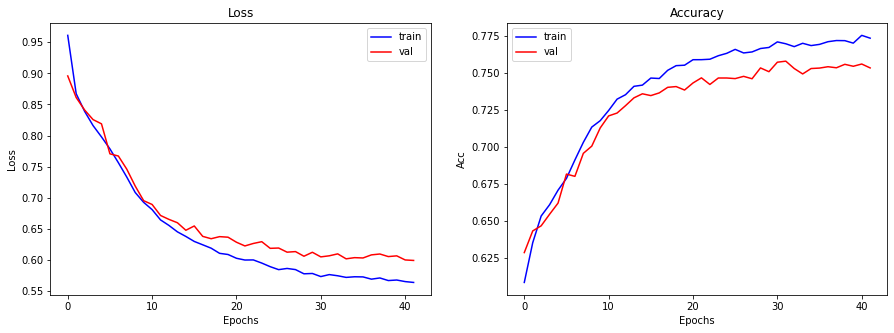

In [25]:
# history filename
history_filename = filename_prefix + ".csv"
print("history_filename: {}".format(history_filename))

# read csv
df = pd.read_csv(history_filename)

# number of epochs
epochs = len(history_dic['valid_acc'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(range(epochs), history_dic['train_loss'], 'b', label='train')
ax1.plot(range(epochs), history_dic['valid_loss'], 'r', label='val')
ax1.set_title("Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(range(epochs), history_dic['train_acc'], 'b', label='train')
ax2.plot(range(epochs), history_dic['valid_acc'], 'r', label='val')
ax2.set_title("Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Acc")
ax2.legend()
plt.show()

### Predict Test Data

In [27]:
print(filename_prefix + ".pth")

# move to gpu
model = model.to(device)

# evaluation
model.eval()

# loss and accuracy
epoch_test_cum_loss = 0.0
epoch_test_cum_corrects = 0

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.long().to(device)

    with torch.no_grad():
        pred_logits = model(images)
        _, pred_classes = torch.max(pred_logits.detach(), dim=1)
        loss = criterion(pred_logits, labels)

        epoch_test_cum_loss += loss.item() * images.size(0)
        epoch_test_cum_corrects += torch.sum(pred_classes==labels.data)

# calculate final loss and accuracy
test_loss = epoch_test_cum_loss / len(data_test)
test_acc = epoch_test_cum_corrects / len(data_test)

# display
print("Test loss: {:.4f}".format(test_loss))
print("Test accuracy: {:.4f}".format(test_acc))

vit_b64_lr00003_ss1_gamma09_E50_e42.pth
Test loss: 0.5885
Test accuracy: 0.7623


## Best model

The current best CNN model is `vit_b64_lr00003_ss1_gamma09_E50_e42.pth`, with the test accuracy = **0.7623**